In [78]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from tqdm import tqdm # 1 to 100%
from IPython.display import display

from statsmodels.formula import api #table
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [79]:
data = pd.read_csv(r"C:\Users\KIRAN SHIKHARE\Downloads\archive (3)\uber.csv")
data.drop(['Unnamed: 0','key'], axis=1, inplace=True)
data.head()
target = 'fare_amount'
features = [i for i in data.columns if i not in [target]]

In [80]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## check for null values and removing them 

In [81]:
data.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [82]:
data.dropna(inplace=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


## Reframing the columns

In [84]:
data.pickup_datetime=pd.to_datetime(data.pickup_datetime)

data['year'] = data.pickup_datetime.dt.year
data['month'] = data.pickup_datetime.dt.month
data['weekday'] = data.pickup_datetime.dt.weekday
data['hour'] = data.pickup_datetime.dt.hour
data.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_longitude   199999 non-null  float64
 2   pickup_latitude    199999 non-null  float64
 3   dropoff_longitude  199999 non-null  float64
 4   dropoff_latitude   199999 non-null  float64
 5   passenger_count    199999 non-null  int64  
 6   year               199999 non-null  int64  
 7   weekday            199999 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 13.7 MB


In [86]:
#Checking number of unique rows in each feature

data.nunique().sort_values()

year                     7
weekday                  7
passenger_count          8
fare_amount           1244
pickup_longitude     71065
dropoff_longitude    76894
pickup_latitude      83835
dropoff_latitude     90585
dtype: int64

In [87]:
#Checking the stats of all the columns

data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,2011.742434,3.048435
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,1.856400,1.946946
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,2009.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,2010.000000,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2012.000000,3.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,2013.000000,5.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,2015.000000,6.000000


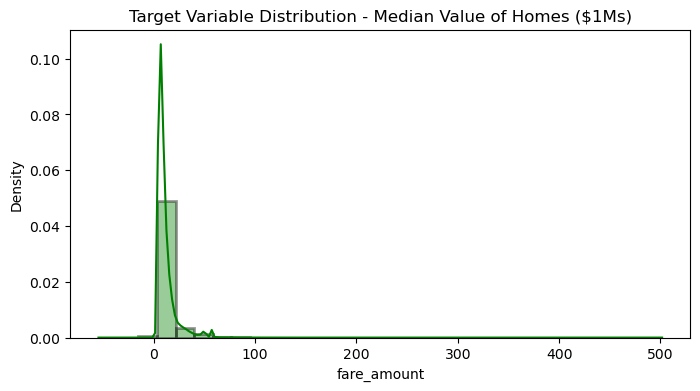

In [88]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(data[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

In [89]:
#Splitting the data intro training & testing sets

m=[]
for i in data.columns.values:
    m.append(i.replace(' ','_'))
    
data.columns = m
X = data.drop([target],axis=1)
Y = data[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

In [90]:
print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (199999, 7) (199999,) 
Training set  --->  (159999, 7) (159999,) 
Testing set   --->  (40000, 7)  (40000,)


In [91]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday
count,1.599990e+05,1.599990e+05,1.599990e+05,1.599990e+05,1.599990e+05,1.599990e+05,1.599990e+05
mean,-6.947375e-16,-1.727518e-17,-1.012030e-15,-1.002249e-15,2.566852e-17,-4.370214e-14,-8.637589e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.095594e+02,-1.537018e+01,-2.472117e+02,-1.726646e+01,-1.287379e+00,-1.477977e+00,-1.566966e+00
25%,-1.268160e-01,1.091656e-01,-1.103724e-01,1.226312e-01,-5.227312e-01,-9.395309e-01,-1.052987e+00
50%,-1.259304e-01,1.115622e-01,-1.095214e-01,1.255339e-01,-5.227312e-01,1.373619e-01,-2.503090e-02
75%,-1.246571e-01,1.135312e-01,-1.082872e-01,1.278050e-01,2.419171e-01,6.758083e-01,1.002926e+00
max,9.791353e+00,2.164399e+02,8.532886e+00,1.261979e+02,3.300510e+00,1.752701e+00,1.516904e+00



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-0.001471,0.006969,-0.000051,-0.000575,0.003519,-0.006619,-0.000681
std,0.939349,1.193013,0.935329,1.140726,1.271167,0.997839,1.003433
min,-57.339587,-15.369394,-50.086940,-139.705744,-1.287379,-1.477977,-1.566966
25%,-0.126806,0.109158,-0.110367,0.122584,-0.522731,-0.939531,-1.052987
50%,-0.125922,0.111572,-0.109512,0.125535,-0.522731,0.137362,-0.025031
75%,-0.124676,0.113522,-0.108264,0.127785,0.241917,0.675808,1.002926
max,11.226374,168.901844,92.293761,0.378772,157.759458,1.752701,1.516904


# Feature Selection/Extraction

                                       Correlation Matrix                                       


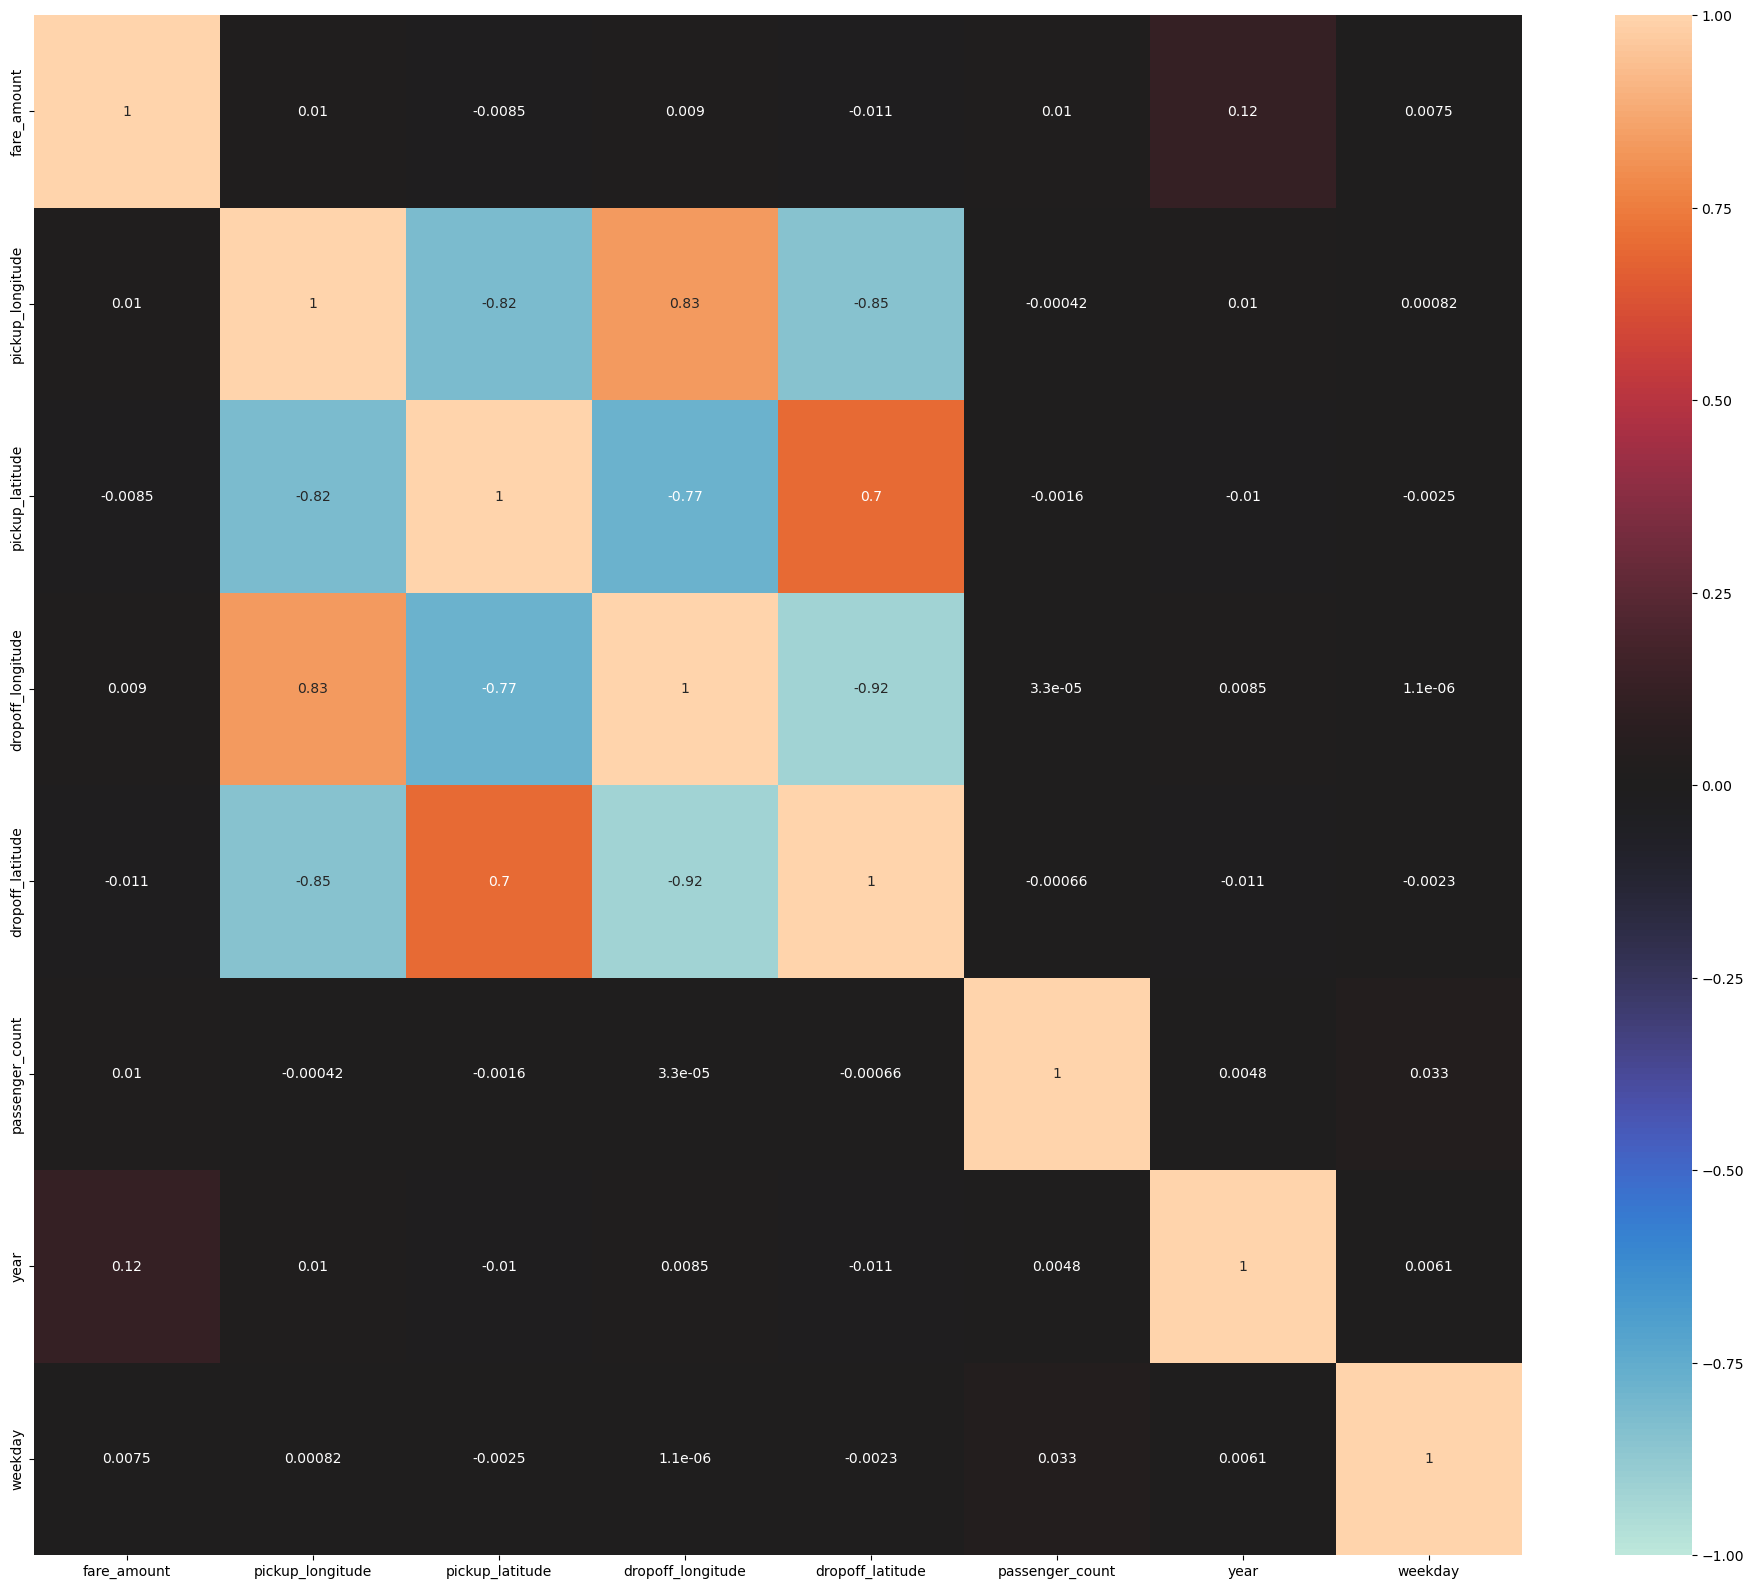

In [92]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [93]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     330.5
Date:                Sat, 29 Jul 2023   Prob (F-statistic):               0.00
Time:                        09:37:09   Log-Likelihood:            -5.9053e+05
No. Observations:              159999   AIC:                         1.181e+06
Df Residuals:                  159991   BIC:                         1.181e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1237.1802     26.268    -47.099      0.000   -1288.664   -1185.696
pickup_longitude      0.0032      0.005      0.651      0.515      -0.006       0.013
pickup_latitude       0.0088      0.012      0.736      0.462      -0.015       0.032
dropoff_longitude    -0.0031      0.006     -0.505      0.614      -0.015       0.009
dropoff_latitude     -0.0237      0.010     -2.254      0.024      -0.044      -0.003
passenger_count       0.0855      0.019      4.608      0.000       0.049       0.122
year                  0.6208      0.013     47.549      0.000       0.595       0.646
weekday               0.0267      0.012      2.138      0.033       0.002       0.051
==============================================================================
Omnibus:                   131553.615   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5387629.584
Skew:                           3.719   Prob(JB):                         0.00
Kurtosis:                      30.437   Cond. No.                     2.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#  Manual Method - VIF

100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


Dropped Features -->  ['pickup_latitude', 'dropoff_latitude', 'pickup_longitude']


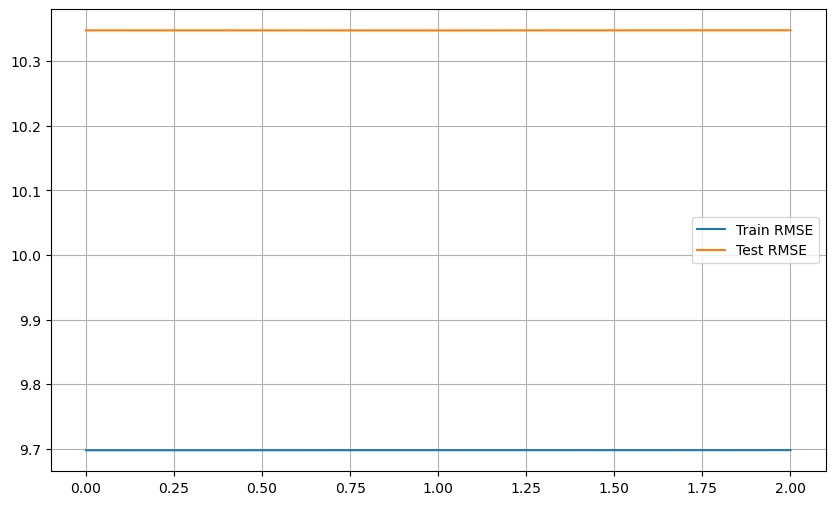

In [94]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
DROP=[];b=[]

for i in tqdm(range(len(Train_X_std.columns)-1)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>=1.1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

# Automatic Method - RFE

100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


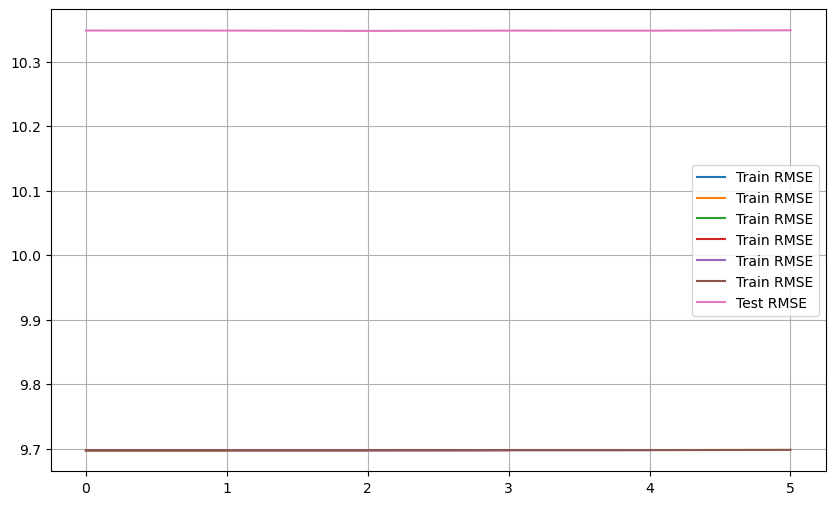

In [95]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=data.shape[1]-2
for i in tqdm(range(m)):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)
    rfe = rfe.fit(Train_X_std, Train_Y)
    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)
    
    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
    plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

# Feature Elmination using PCA Decomposition

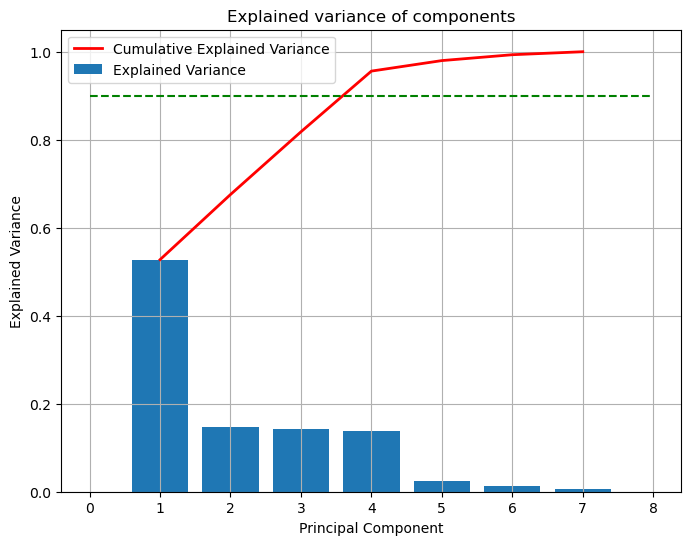

In [96]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


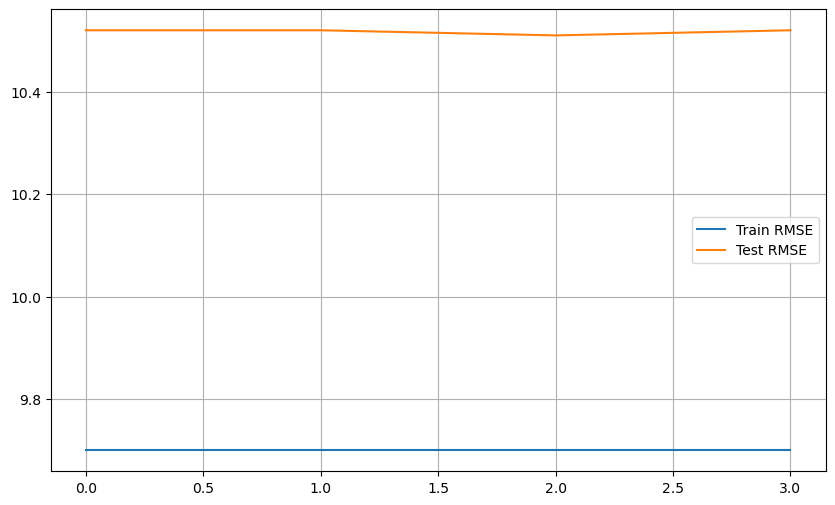

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=data.shape[1]-4

for i in tqdm(range(m)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

# Predictive Modelling

In [98]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

# Multiple Linear Regression(MLR)

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.03650162  0.06493671 -0.04091748 -0.156081    0.11177797  1.15295863
  0.05186402]
The Intercept of the Regresion Model was found to be  11.349275807973848


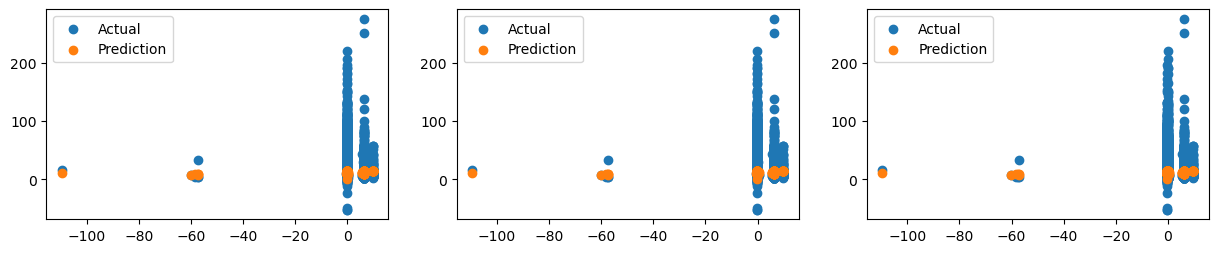



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.014253751823228189
Residual Sum of Squares (RSS) on Training set  ---> 15046683.673265526
Mean Squared Error (MSE) on Training set       ---> 94.04236072266406
Root Mean Squared Error (RMSE) on Training set ---> 9.697544056237335

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.013991251074848552
Residual Sum of Squares (RSS) on Training set  ---> 4283643.400623001
Mean Squared Error (MSE) on Training set       ---> 107.09108501557503
Root Mean Squared Error (RMSE) on Training set ---> 10.34848225661981

--------------------Residual Plots--------------------


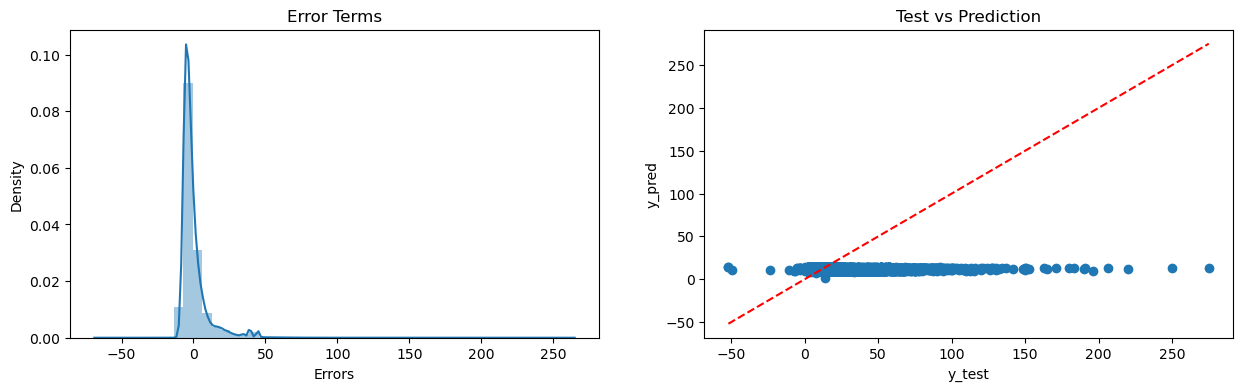

In [99]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

# Ridge Regression Model

<<<------------------------- Evaluating Ridge Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.03650162  0.06493671 -0.04091748 -0.156081    0.11177797  1.15295863
  0.05186402]
The Intercept of the Regresion Model was found to be  11.349275807973848


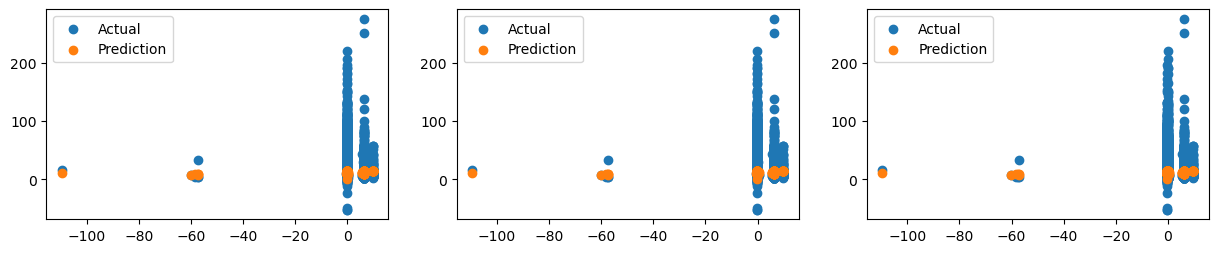



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.014253751822555394
Residual Sum of Squares (RSS) on Training set  ---> 15046683.673275795
Mean Squared Error (MSE) on Training set       ---> 94.04236072272823
Root Mean Squared Error (RMSE) on Training set ---> 9.697544056240643

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.013991265552614984
Residual Sum of Squares (RSS) on Training set  ---> 4283643.337725396
Mean Squared Error (MSE) on Training set       ---> 107.0910834431349
Root Mean Squared Error (RMSE) on Training set ---> 10.348482180645377

--------------------Residual Plots--------------------


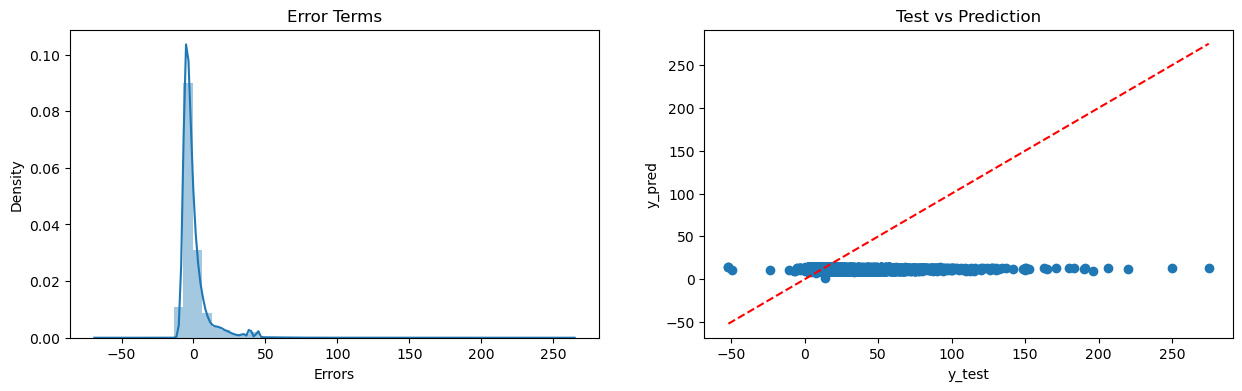

In [100]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

# Lasso Regression Model

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.03650162  0.06493671 -0.04091748 -0.156081    0.11177797  1.15295863
  0.05186402]
The Intercept of the Regresion Model was found to be  11.349275807973848


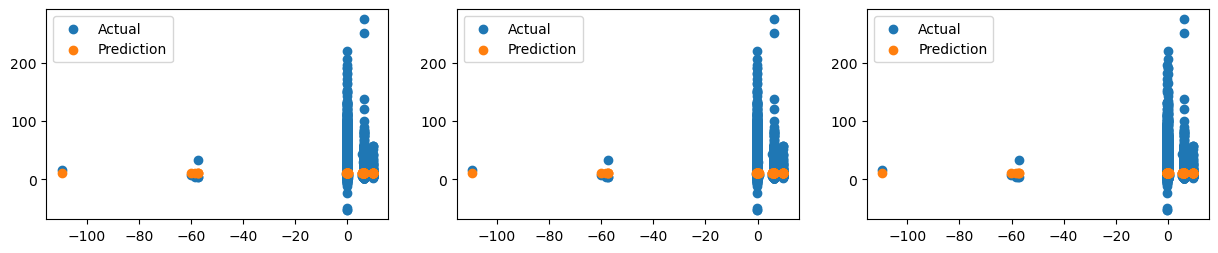



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.003506890312316213
Residual Sum of Squares (RSS) on Training set  ---> 15210726.524997573
Mean Squared Error (MSE) on Training set       ---> 95.0676349539533
Root Mean Squared Error (RMSE) on Training set ---> 9.750263327415999

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.003283074551932663
Residual Sum of Squares (RSS) on Training set  ---> 4330164.295843351
Mean Squared Error (MSE) on Training set       ---> 108.25410739608377
Root Mean Squared Error (RMSE) on Training set ---> 10.404523410328979

--------------------Residual Plots--------------------


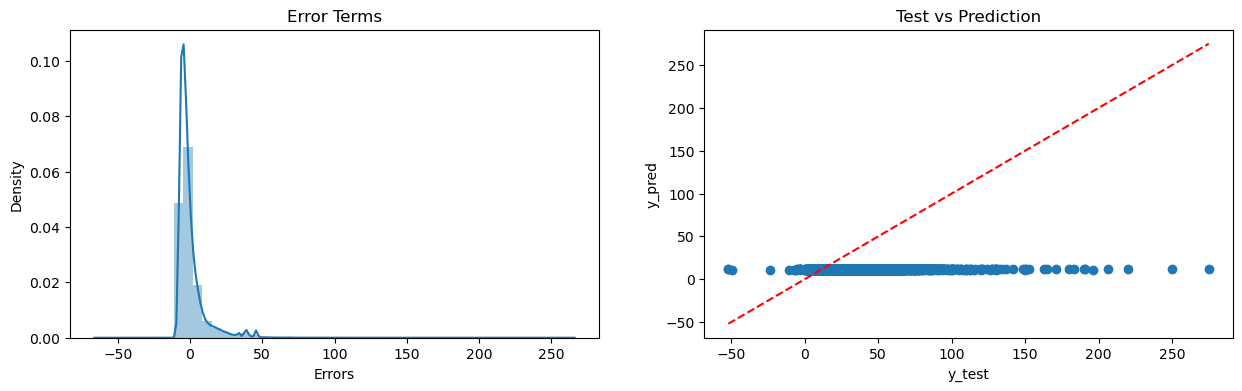

In [101]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

#  Elastic-Net Regression

<<<------------------------- Evaluating Elastic-Net Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.03650162  0.06493671 -0.04091748 -0.156081    0.11177797  1.15295863
  0.05186402]
The Intercept of the Regresion Model was found to be  11.349275807973848


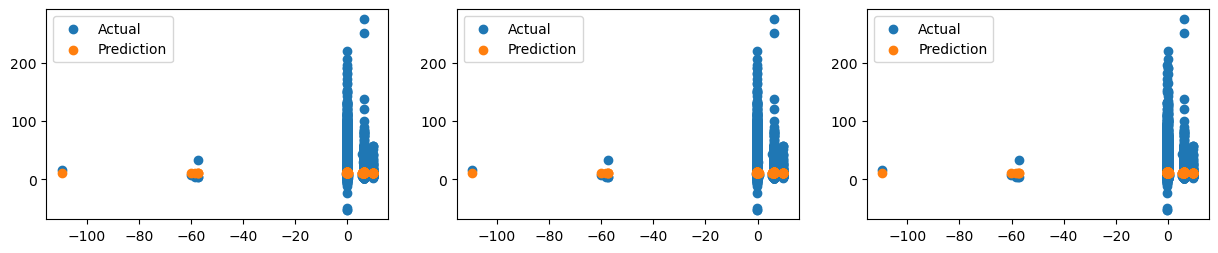



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.008578945975973973
Residual Sum of Squares (RSS) on Training set  ---> 15133305.36586518
Mean Squared Error (MSE) on Training set       ---> 94.58374968509291
Root Mean Squared Error (RMSE) on Training set ---> 9.725417712627715

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.008157856033748745
Residual Sum of Squares (RSS) on Training set  ---> 4308986.161727579
Mean Squared Error (MSE) on Training set       ---> 107.7246540431895
Root Mean Squared Error (RMSE) on Training set ---> 10.379048802428356

--------------------Residual Plots--------------------


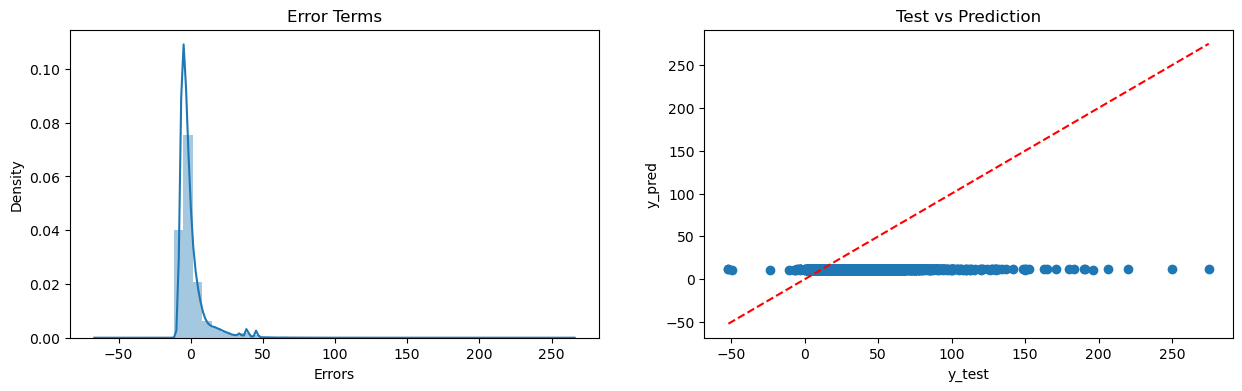

In [102]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

#  Polynomial Regression Model

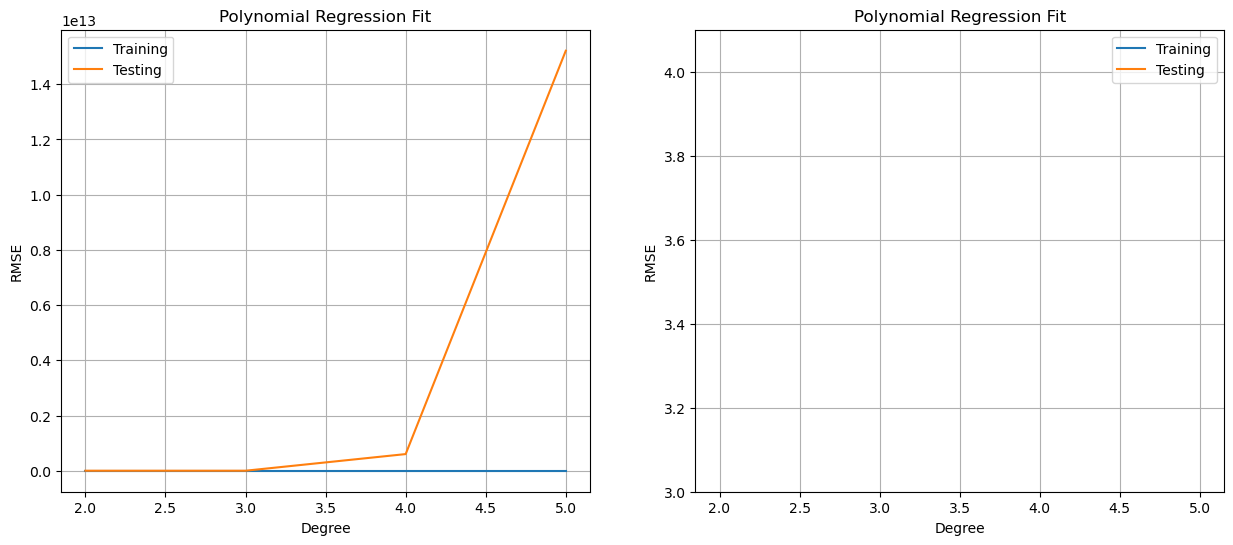

In [103]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=6

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([3,4.1])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<------------------------- Evaluating Polynomial Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 0.03650162  0.06493671 -0.04091748 -0.156081    0.11177797  1.15295863
  0.05186402]
The Intercept of the Regresion Model was found to be  11.349275807973848


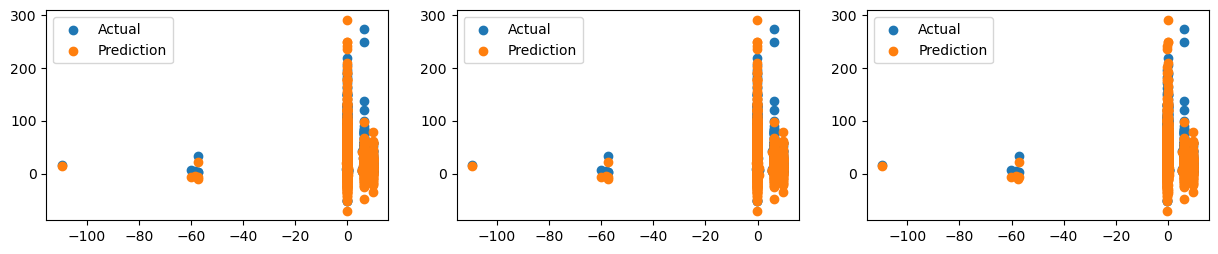



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.6225309740954104
Residual Sum of Squares (RSS) on Training set  ---> 5761784.069426668
Mean Squared Error (MSE) on Training set       ---> 36.01137550501358
Root Mean Squared Error (RMSE) on Training set ---> 6.000947883877478

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -2.131399861521136e+24
Residual Sum of Squares (RSS) on Training set  ---> 9.259711905037944e+30
Mean Squared Error (MSE) on Training set       ---> 2.314927976259486e+26
Root Mean Squared Error (RMSE) on Training set ---> 15214887368165.057

--------------------Residual Plots--------------------


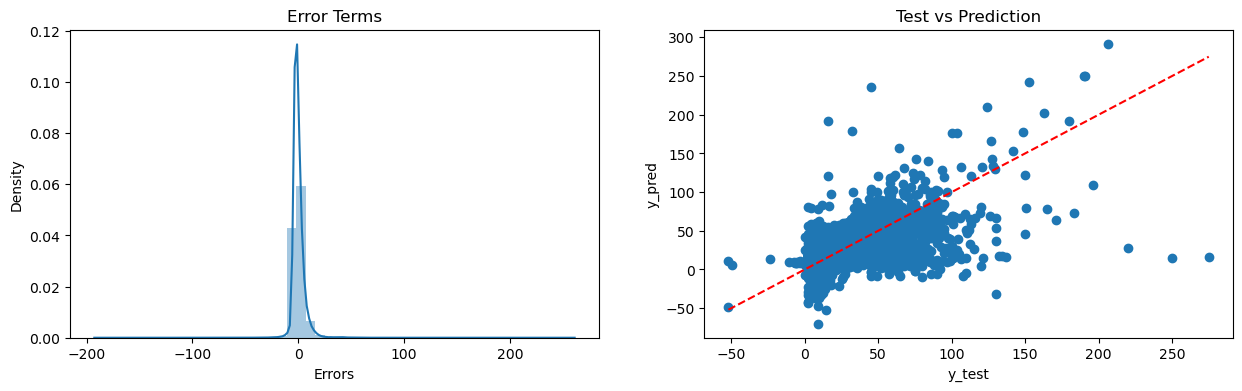

In [104]:
#Using the 5th Order Polynomial Regression model (degree=5)

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

# Comparing the Evaluation Metics of the Models

In [105]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.014254,1.399125e-02,1.504668e+07,4.283643e+06,94.042361,1.070911e+02,9.697544,1.034848e+01
Ridge Linear Regression (RLR),0.014254,1.399127e-02,1.504668e+07,4.283643e+06,94.042361,1.070911e+02,9.697544,1.034848e+01
Lasso Linear Regression (LLR),0.003507,3.283075e-03,1.521073e+07,4.330164e+06,95.067635,1.082541e+02,9.750263,1.040452e+01
Elastic-Net Regression (ENR),0.008579,8.157856e-03,1.513331e+07,4.308986e+06,94.583750,1.077247e+02,9.725418,1.037905e+01
Polynomial Regression (PNR),0.622531,-2.131400e+24,5.761784e+06,9.259712e+30,36.011376,2.314928e+26,6.000948,1.521489e+13


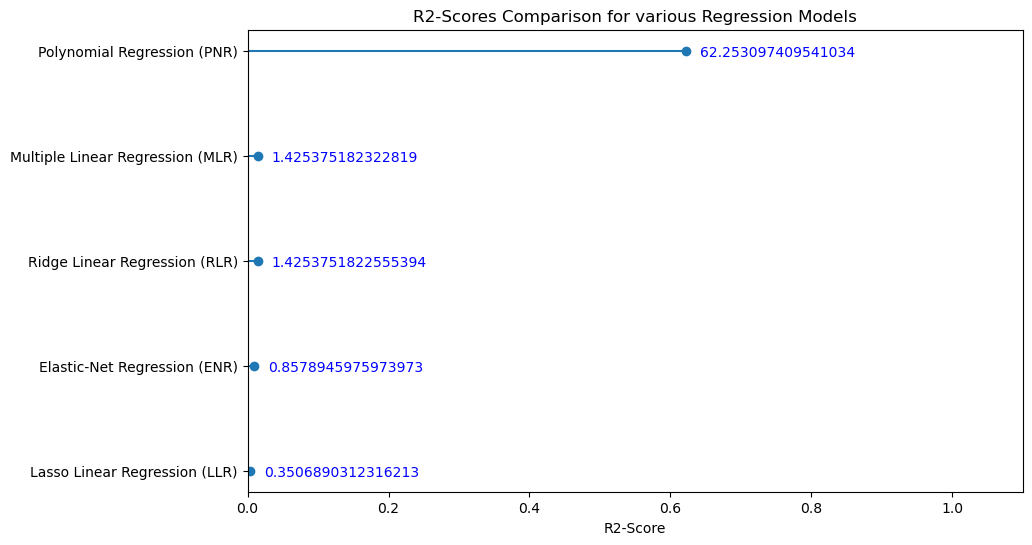

In [106]:
# R2-Scores Comparison for different Regression Models

R2 = EMC['Train-R2'].sort_values(ascending=True)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()